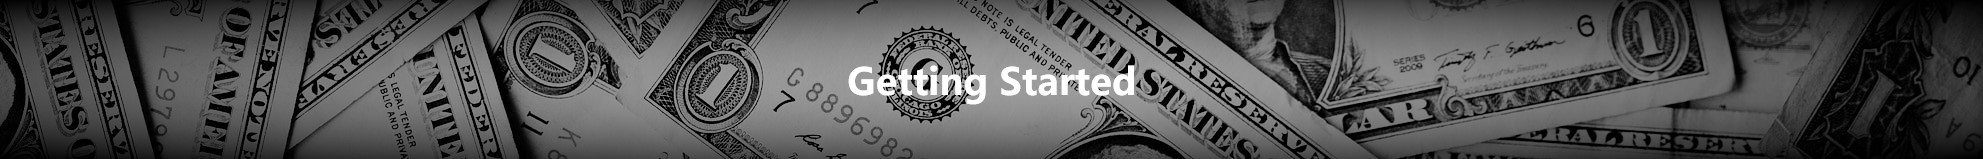

This project is **<font color='#6dafd7'>focused on predicting the salaries on the realm of data science based</font>** on <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>experience level</span>, <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>company_size</span>, <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>employment type</span>, and <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>geography</span>. Through advanced algorithms and a diverse dataset, we aim to uncover the key factors influencing data scientists' compensation.

<img src="images/photo2.png" align="center"/>

### Domain Knowledge

<span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>numpy.array [categorical]</span>: The "Year" attribute in our dataset represents the specific year in which the salary was disbursed, taking into account the potential impact of different economic conditions on the salary levels of data scientists.

<span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>experience_level [categorical]</span>: The level of experience a person holds in a job, impacting salary calculation, as more experienced individuals typically receive higher pay due to advanced skills and knowledge.

<span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>employment_type [categorical]</span>: The nature of the employment contract, such as full-time, part-time, or contractual, significantly influencing the salary, with full-time employees often receiving higher annual pay compared to part-time or contractual counterparts.

<span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>job_title [categorical]</span>: The role an individual holds within a company, with different roles having varying salary scales based on responsibilities and required skills (e.g., managerial roles typically have higher pay than entry-level positions).

<span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>salary [numerical]</span>: The total gross salary paid to the individual, directly influenced by factors like experience level, job title, and employment type.

<span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>salary_currency [categorical]</span>: The specific currency in which the salary is paid, denoted by an ISO 4217 code, taking into account exchange rates that could affect the salary value when converted into different currencies.

<span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>salary_in_usd [numerical]</span>: The total gross salary amount converted to US dollars, allowing for a uniform comparison of salaries across different countries and currencies.

<span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>employee_residence [categorical]</span>: The primary country of residence of the employee, denoted by an ISO 3166 code, impacting salary levels due to cost of living and prevailing wage rates in the country.

<span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>remote_ratio [categorical]</span>: The proportion of work done remotely, where companies may adjust salaries based on the cost of living in the employee's location and the extent of remote work.

<span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>company_location [categorical]</span>: The location of the employer's main office or branch holding the contract, with companies in different locations offering different salary scales due to varying economic conditions and cost of living.

<span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>company_size [categorical]</span>: The median number of employees in the company during the work year, with larger companies often having structured salary scales and offering higher salaries due to economies of scale and larger revenue streams.

**💸💸💸These attributes, with the right statistical and machine learning techniques can give us a model to predict someone's salary💸💸💸**

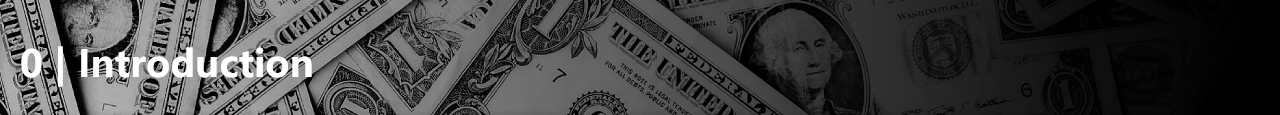

### **I <font color='green'>|</font> Preface**

<span style='color: #FFFFFF; font-family: monospace; background-color: #6dafd7;'>Logistic Regression</span>, <span style='color: #FFFFFF; font-family: monospace; background-color: #6dafd7;'>RandomForest</span>, <span style='color: #FFFFFF; font-family: monospace; background-color: #6dafd7;'>Naive Bayes</span>, <span style='color: #FFFFFF; font-family: monospace; background-color: #6dafd7;'>Support Vector Machines</span>, and <span style='color: #FFFFFF; font-family: monospace; background-color: #6dafd7;'>Gradient Boosting Classifier</span> are utilized in analyzing this type of data. These models are known for their distintc strenths when dealing with diverse data types and structure.

The criterias for selecting these models are as follows:

1. **Able to Handle Both Data Types**: All models - **<font color='#6dafd7'>Logistic Regression</font>**, **<font color='#6dafd7'>RandomForest</font>**, **<font color='#6dafd7'>Naive Bayes</font>**, **<font color='#6dafd7'>Support Vector Machines</font>**, and **<font color='#6dafd7'>Gradient Boosting Classifier</font>** - possess the ability to effectively handle a wide range of data types in our dataset, encompassing both numerical and categorical variables. This adaptability is especially advantageous due to the diversity of features present, such as <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>work year</span>, <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>experience level</span>, <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>employment type</span>, <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>job title</span>, <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>salary</span>, <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>salary currency</span>, <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>salary in USD</span>, <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>employee residence</span>, <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>remote ratio</span>, <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>company location</span>, and <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>company size</span>.

2. **Generalization**:  **<font color='#6dafd7'>RandomForest</font>**, **<font color='#6dafd7'>Support Vector Machines</font>**, and **<font color='#6dafd7'>Gradient Boosting Classifier</font>** are machine learning models which excels on generalizing new, and unseen data. Both **<font color='#6dafd7'>RandomForest</font>**, and **<font color='#6dafd7'>Gradient Boosting Classifier</font>** utilizes an ensemble learning technique that combines multiple weak learners **<span style='color: #000000; font-family: monospace; background-color: #959696;'>(typically decision trees)</span>**. By sequentially adding trees to correct the errors made by the previous ones, it creates a robust and generalized model. While Support Vector Machine uses margin maximation which aims to find a hyperplane that maximizes the margin between different classes. This focus on maximizing the margin can lead to better generalization and reduced overfitting.

3. **Handling Non-Linearity**: Dataset can contain a complex and non-linear relationships. It is important to include models that handles and capture intricate relationships between feature and target variable. **<font color='#6dafd7'>RandomForest</font>**, **<font color='#6dafd7'>Support Vector Machines</font>**, and **<font color='#6dafd7'>Gradient Boosting Classifier</font>** are models selected for this type of data.

4. **Effective with Large Dataset**: With the given dataset it is crucial to include machine learning models that are capable of efficiently handling large data set. **<font color='#6dafd7'>Naive Bayes</font>**, **<font color='#6dafd7'>Logistic Regression</font>**, **<font color='#6dafd7'>RandomForest</font>**, and **<font color='#6dafd7'>Gradient Boosting Classifier</font>** were selected for this.

5. **Efficient with High-Dimension Data**: **<font color='#6dafd7'>Support Vector Machines</font>**, **<font color='#6dafd7'>Gradient Boosting Classifier</font>**, and **<font color='#6dafd7'>RandomForest</font>** are models that are able to handle high-dimension data efficiently.

**II <font color='green'>|</font> Import Libraries**

In [464]:
import warnings
warnings.filterwarnings('ignore')

# Import essentials
import pandas as pd
import numpy as np

# Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# Import Sci-kit for Machine Learning Libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Import Statistics libraries
from scipy import stats
from scipy.stats import norm

# Import country code libraries
import pycountry

#Install plot library
import plotly.io as pio
#pio.renderers.default='notebook'

**III <font color='green'>|</font> Input Dataset**

In [465]:
df = pd.read_csv('ds_salaries.csv')

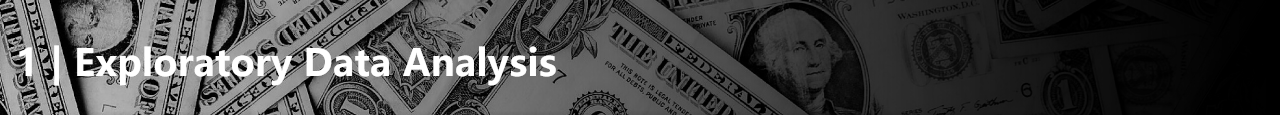

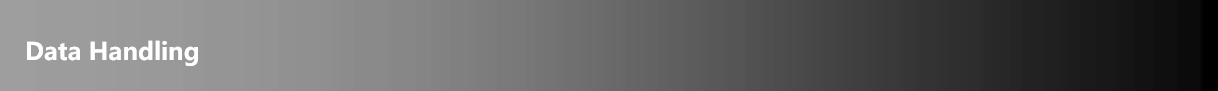

**I <font color='green'>|</font> Check for Number of Uniques**

In [466]:
# Check uniques in a row
df.nunique()

work_year                4
experience_level         4
employment_type          4
job_title               93
salary                 815
salary_currency         20
salary_in_usd         1035
employee_residence      78
remote_ratio             3
company_location        72
company_size             3
dtype: int64

**II <font color='green'>|</font> Check for Number of Null**

In [467]:
# Check for missing data in a row
df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

**III <font color='green'>|</font> Check for Duplicates on a Column**

In [468]:
# Check for duplicated data in a column
df_transposed = df.transpose()
duplicates = df_transposed.index[df_transposed.duplicated()].nunique()
duplicates

0

**IV <font color='green'>|</font> Explore the Data**

In [469]:
# Show the head
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


**V <font color='green'>|</font> Renaming Data**

In [470]:
df.experience_level = df.experience_level.replace({'EN': 'Entry Level',
                                                   'MI': 'Mid/Intermediate Level',
                                                   'SE': 'Senior Level',
                                                   'EX': 'Executive Level'})

df.employment_type = df.employment_type.replace({'FL': 'Freelancer',
                                                 'CT': 'Contractor',
                                                 'PT': 'Part-time',
                                                 'FT': 'Full-time'})

df.company_size = df.company_size.replace({'S': 'SMALL',
                                           'M': 'MEDIUM',
                                           'L': 'LARGE'})

df.remote_ratio = df.remote_ratio.astype(str)
df.remote_ratio = df.remote_ratio.replace({'0': 'On-Site',
                                           '50': 'Half-Remote',
                                           '100' : 'Full-Remote'}) 

**VI <font color='green'>|</font> Group the Job Title**

In [471]:
def assign_broader_category(job_title):
    data_engineering = ["Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst", "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"]
    data_scientist = ["Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher", "Deep Learning Researcher", "AI/Computer Vision Engineer"]
    machine_learning = ["Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    management = ["Data Science Manager", "Director of Data Science", "Head of Data Science", "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management", "Data Analytics Manager"]
    
    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

# Apply the function to the 'job_title' column and create a new column 'job_category'
df['job_category'] = df['job_title'].apply(assign_broader_category)

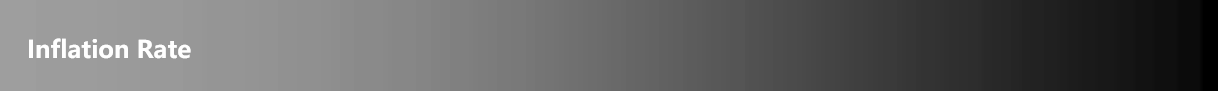

**VII <font color='green'>|</font> Adjust Salaries to Present Value**

<img src="images/inflation.PNG" align="center"/>

Various currencies are observed on the salaries with different year. To accurately analyze and compare these salaries we need to convert the salaries into a uniform currency and take into account the inflation to adjust the value of salary to its current value. Adjusting and converting salaries to a specific currency and year, we can make an accurate comparison to analyze its relation to other features.

<img src="images/inflation formula.PNG" align="center"/>

#### **I <font color='green'>|</font> Explanation**


1. **Determine inflation rates** for both the United States (US) and global markets. These rates will be applied to adjust salaries based on the respective year and currency.

2. Implement a function named **adjust_salary()** that takes a row from the dataset as input and calculates the adjusted salary based on the work year, original salary, and currency. If the work year is 2023, no salary adjustment is required, and the original salary will be retained.

3. Calculate the **number of years between the work year and 2023**. Use the appropriate inflation rate based on the currency, either the US or global inflation rate.

4. Compute the adjusted salary by **applying the inflation rate** to the original salary for each year from the work year to 2023.

5. **Apply the adjust_salary()** function to the dataset using the apply() method, and create a new column named 'adjusted_salary' to store the adjusted salary values.

In [472]:
# Inflation rates
us_inflation_rates = {2019: 0.0181, 2020: 0.0123, 2021: 0.0470, 2022: 0.065}
global_inflation_rates = {2019: 0.0219, 2020: 0.0192, 2021: 0.0350, 2022: 0.088}

# Function to adjust salary
def adjust_salary(row):
    year = row.work_year
    original_salary = row.salary_in_usd
    currency = row.salary_currency

    if year == 2023:
        return original_salary

    adjusted_salary = original_salary
    for y in range(year, 2023):
        if currency == 'USD':
            inflation_rate = us_inflation_rates[y]
        else:
            inflation_rate = global_inflation_rates[y]

        adjusted_salary *= (1 + inflation_rate)

    return adjusted_salary

# Apply the function to the dataset
df['adjusted_salary'] = df.apply(adjust_salary, axis=1)

#------------
#credit : @rrrrrrita
#------------

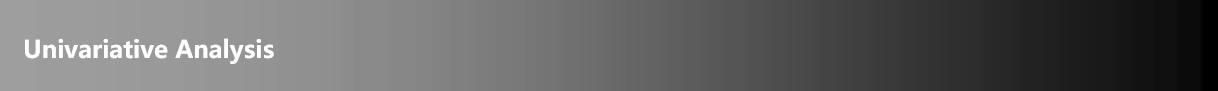

**VIII <font color='green'>|</font> Job Distribution**

Text(0.5, 1.0, 'Job Titles Percentage')

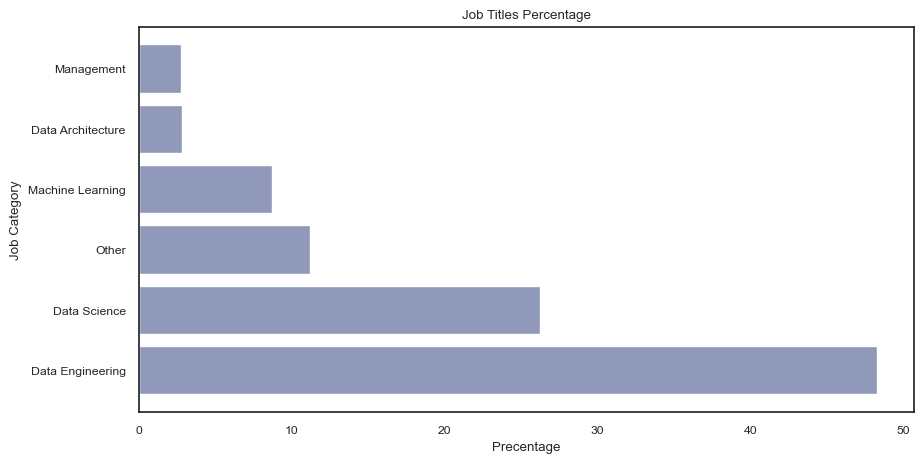

In [473]:
value_counts = df.job_category.value_counts(normalize=True) *100
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(value_counts.index[:], value_counts.values[:], color='#9099BA' , align='center')
ax.set_xlabel('Precentage')
ax.set_ylabel('Job Category')
ax.set_title('Job Titles Percentage')

#### **<font color='green'>|</font> Explanation**

Roles in **Data Engineering** makes up almost half of the total jobs on the data with management makes up the least.

**IX <font color='green'>|</font> Salary Distribution**

Text(0, 0.5, 'Adjusted Salary')

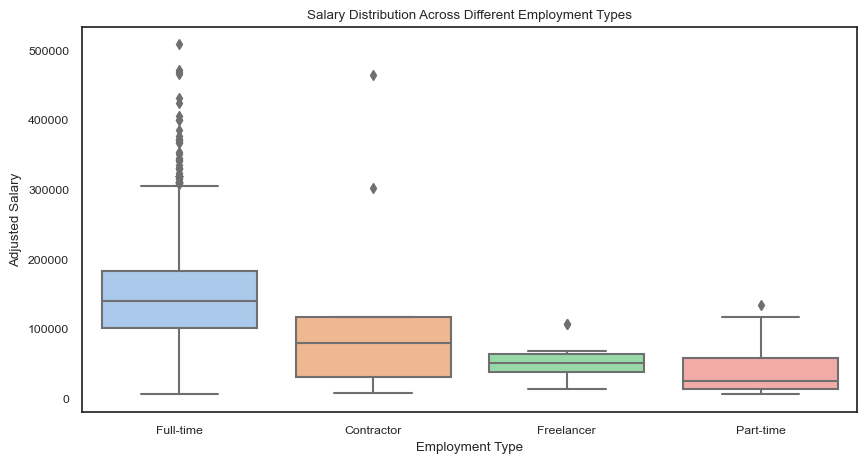

In [474]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='employment_type', y='adjusted_salary', palette='pastel')
plt.title('Salary Distribution Across Different Employment Types')
plt.xlabel('Employment Type')
plt.ylabel('Adjusted Salary')

#### **<font color='green'>|</font> Explanation**

**Full-time** job earns the most with the majority earns 100k-200k.

**X <font color='green'>|</font> Distribution of Salary**

Adjusted Salary Mu: 142445.65920779307, Sigma: 64692.97536803713
Adjusted Salary Skewness: 0.5766891651013609, Sigma: 1.13584749981765


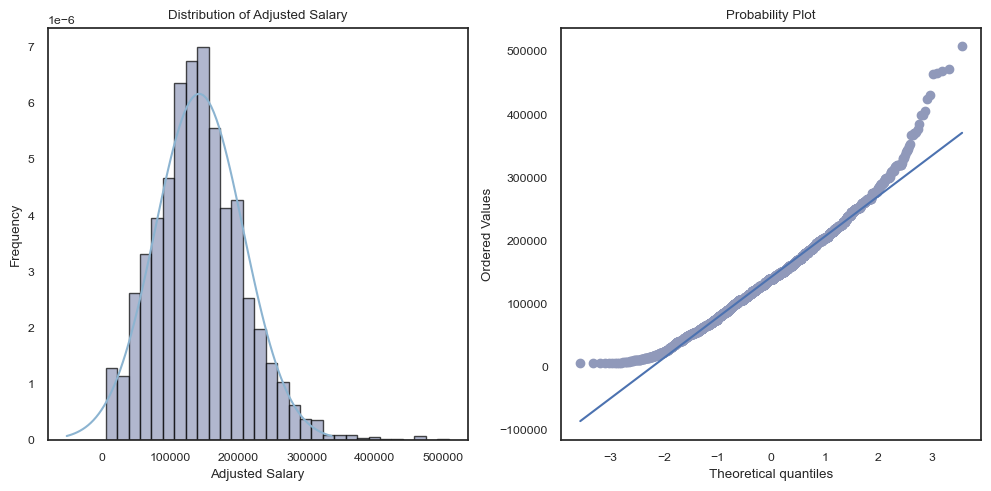

In [475]:
 # Plot the distribution of the data

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
ax1.hist(df.adjusted_salary, bins=30, density=True, alpha=0.7, color='#9099BA', edgecolor='black')

# Fit a normal distribution to the data
(mu, sigma) = stats.norm.fit(df.adjusted_salary)
print(f'Adjusted Salary Mu: {mu}, Sigma: {sigma}')

# Calculate the skewness and kurtosis of the data
print(f'Adjusted Salary Skewness: {df.adjusted_salary.skew()}, Sigma: {df.adjusted_salary.kurt()}')

# Add the fitted normal distribution to the plot
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = stats.norm.pdf(x, mu, sigma)
ax1.plot(x, y, label='Normal fit')

#Add labels and title to the plot
ax1.set_xlabel('Adjusted Salary')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Adjusted Salary')

# Plot the QQ-plot
stats.probplot(df.adjusted_salary, plot=ax2)
ax2.get_lines()[0].set_color('#9099BA')
ax2.get_lines()[1].set_color('b')

plt.tight_layout()       
plt.show()
    

#### **<font color='green'>|</font> Explanation**

Jobs at **data science** realm pays an average of 150k USD.

**XI <font color='green'>|</font> Boxplot and Swarmplot of Adjusted Salary**

count      3755.00
mean     142445.66
std       64701.59
min        5583.62
25%      100000.00
50%      139000.00
75%      181050.00
max      507946.58
Name: adjusted_salary, dtype: object

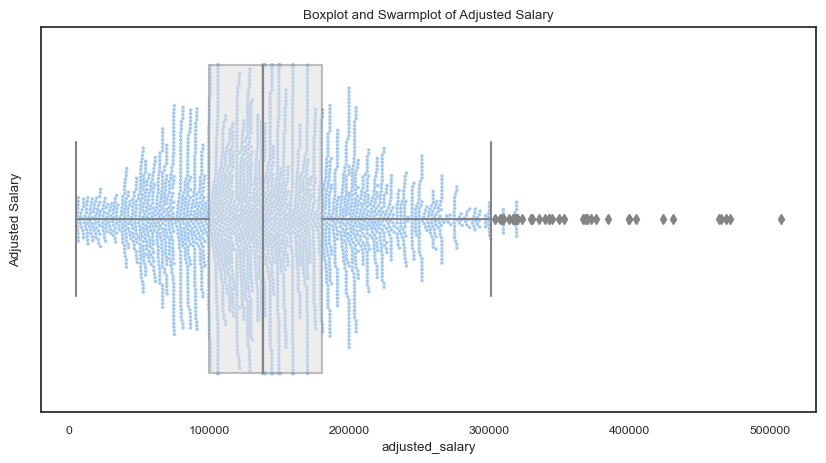

In [476]:
formatted_data = df.loc[:, 'adjusted_salary'].describe().apply(lambda x: f'{x:.2f}')

plt.figure(figsize=(10,5))
sns.swarmplot(x=df.adjusted_salary, palette='pastel', zorder=.5, size=2.5)
sns.boxplot(x=df.adjusted_salary, palette='coolwarm', boxprops=dict(alpha=.5))
plt.ylabel('Adjusted Salary')
plt.title('Boxplot and Swarmplot of Adjusted Salary')

formatted_data

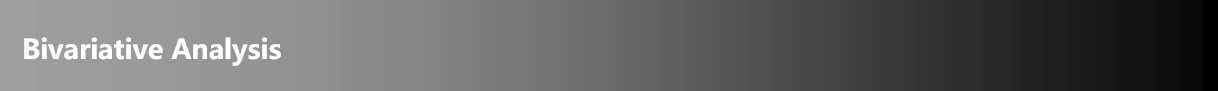

**XII <font color='green'>|</font> Median Salary by Job Title**

Text(0.5, 1.0, 'Median Salary by Year')

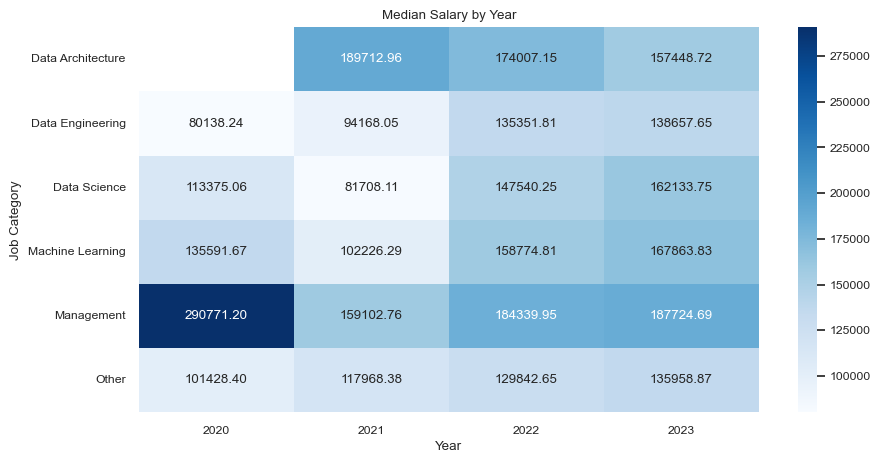

In [477]:
pivot_table = df.pivot_table(values='adjusted_salary', index='job_category', columns='work_year', aggfunc='mean')
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_table, fmt='.2f', annot=True, cmap='Blues')
plt.xlabel('Year')
plt.ylabel('Job Category')
plt.title('Median Salary by Year')

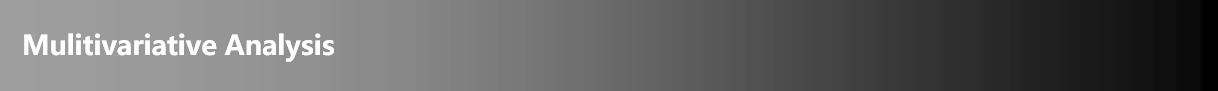

**XIII <font color='green'>|</font> Salary Comparison Betweeon Residence and Company Location**

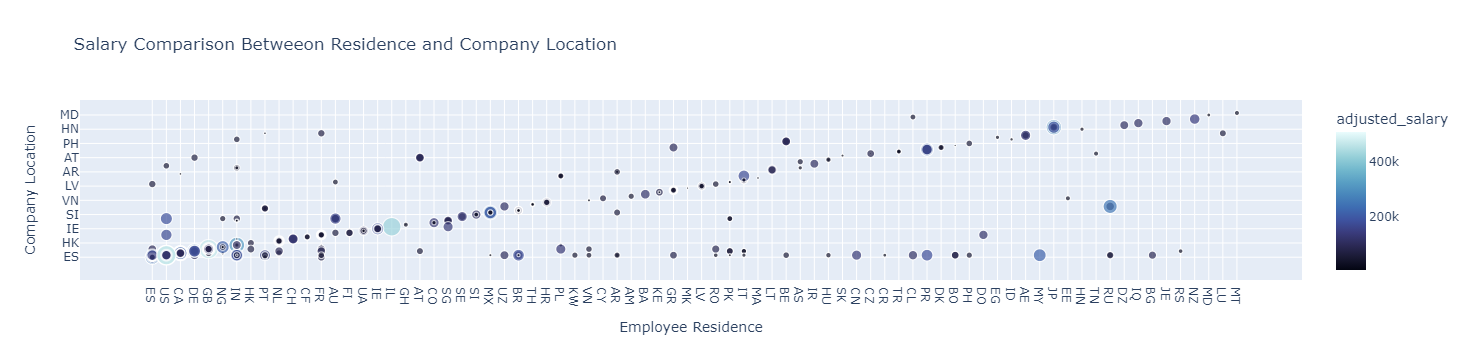

In [478]:

df.adjusted_salary = df.adjusted_salary.astype(float).round(2)
fig = px.scatter(data_frame=df, x='employee_residence', y='company_location', color='adjusted_salary', size='adjusted_salary', color_continuous_scale='ice',
                labels={'company_location': 'Company Location',
                        'employee_residence': 'Employee Residence'},
                title='Salary Comparison Betweeon Residence and Company Location')


fig.show()

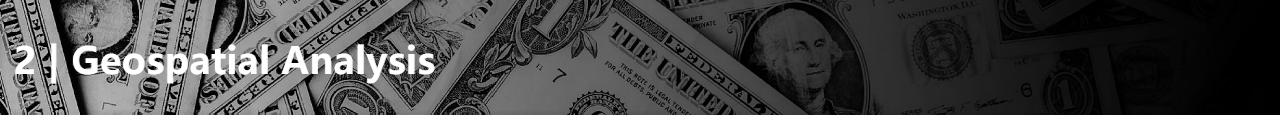

**I <font color='green'>|</font> Convert Country Code to Country Name**

In [479]:
# Function to convert ISO 3166 country code to country name
def country_code_to_name(country_code):
    try:
        return pycountry.countries.get(alpha_2=country_code).name
    except:
        return country_code
    # Function to convert country code to full name
def country_code_to_name(code):
    try:
        country = pycountry.countries.get(alpha_2=code)
        return country.name
    except:
        return None

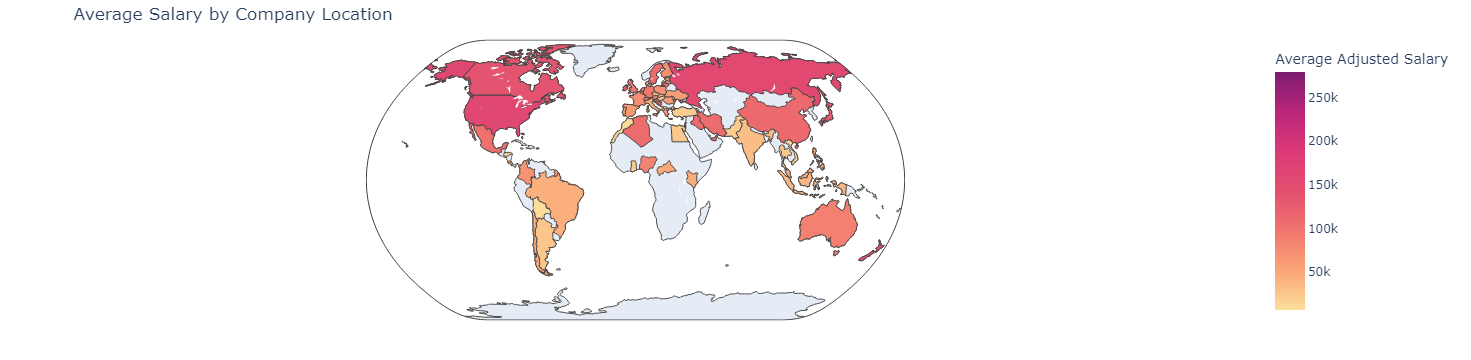

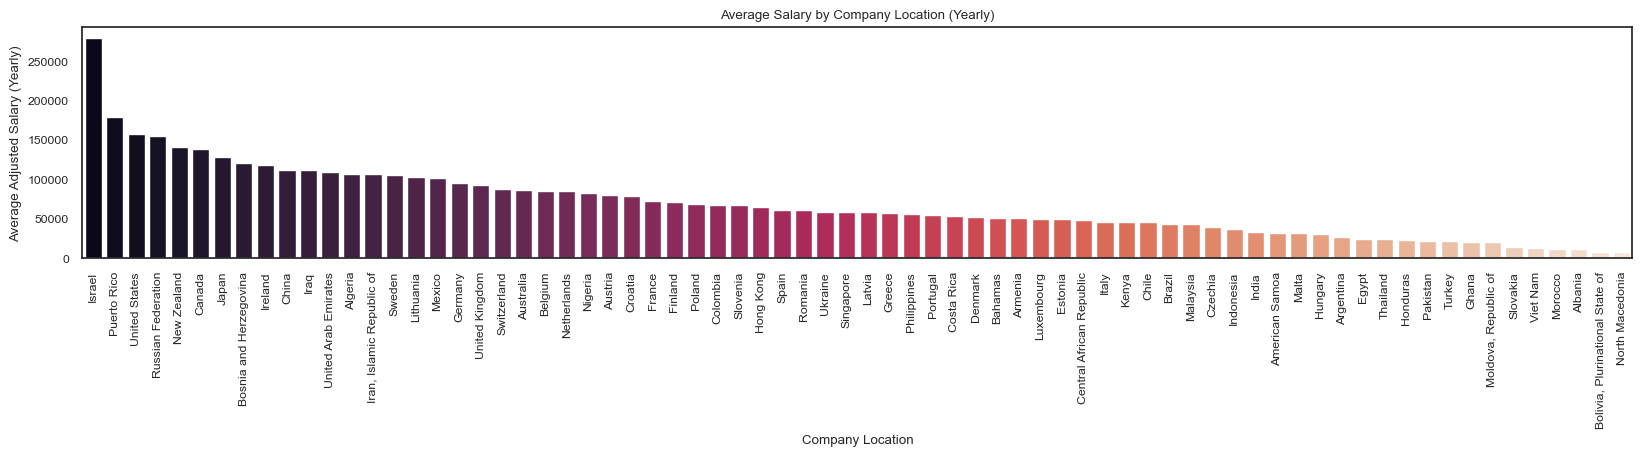

In [480]:
df.company_location = df.company_location.apply(country_code_to_name)
df.employee_residence = df.employee_residence.apply(country_code_to_name)

average_salary_by_location = df.groupby('company_location', as_index=False)['adjusted_salary'].mean()

fig1 = px.choropleth(average_salary_by_location, 
                     locations='company_location', 
                     locationmode='country names',
                     color='adjusted_salary',
                     hover_name='company_location',
                     color_continuous_scale='sunsetdark',
                     title='Average Salary by Company Location',
                     labels={'adjusted_salary': 'Average Adjusted Salary'},
                     projection='natural earth')
fig1.update_layout(margin=dict(l=30, r=30, t=40, b=40))
fig1.show()

# Average salary by company_location
avg_salary_by_location = df.groupby('company_location')['adjusted_salary'].mean().sort_values(ascending=False)
plt.figure(figsize=(20, 3))
sns.barplot(x=avg_salary_by_location.index, y=avg_salary_by_location, palette='rocket')
plt.title('Average Salary by Company Location (Yearly)')
plt.xlabel('Company Location')
plt.ylabel('Average Adjusted Salary (Yearly)')
plt.xticks(rotation=90)
plt.show()


### **<font color='green'>|</font> Summary of Findings**

1. Upon analyzing the distribution of adjusted salaries, it becomes apparent that a significant proportion of **data management professionals earn annual salaries ranging from 100,000 to 180,500 USD**. Nevertheless, there is a notable group of high earners who surpass the average by a considerable margin.

2. A closer look at the average salary based on company location reveals that data scientists working for companies in countries such as **Israel, USA, and Russia tend to enjoy higher average salaries. Conversely, companies situated in regions like South East Asia, Africa, and Eastern Europe offer relatively lower average salaries** to data science professionals.

3. Additionally, the analysis of average salary by employee residence suggests that data scientists residing in countries like **Israel, USA, and Malaysia** generally command higher average salaries. Conversely, data scientists living in countries like Slovakia, Morocco, and North Macedonia tend to have lower average salaries.

4. When comparing employee residence to company location, it becomes evident that some data scientists may secure high salaries by working for companies situated in countries with lucrative job markets. Others, however, might need to explore relocation or remote work opportunities to access such high-paying positions

**<font color='#6dafd7' style='font-family: Helvetica'>To sum up, the examination of data science job salaries reveals the significance of various factors, such as company location and employee residence, in shaping salary trends. This valuable insight equips job seekers and employers to make informed choices regarding job prospects, competitive compensation offers, and effective talent acquisition strategies.</font>**


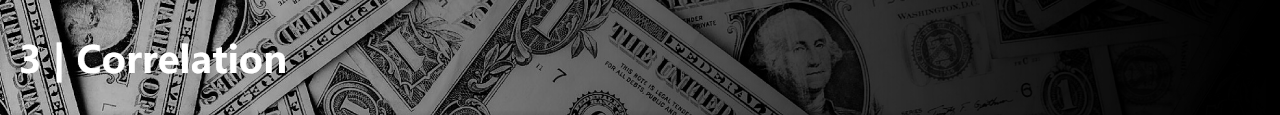

**I <font color='green'>|</font> Display Data**

In [481]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_category,adjusted_salary
0,2023,Senior Level,Full-time,Principal Data Scientist,80000,EUR,85847,Spain,Full-Remote,Spain,LARGE,Other,85847.0
1,2023,Mid/Intermediate Level,Contractor,ML Engineer,30000,USD,30000,United States,Full-Remote,United States,SMALL,Machine Learning,30000.0
2,2023,Mid/Intermediate Level,Contractor,ML Engineer,25500,USD,25500,United States,Full-Remote,United States,SMALL,Machine Learning,25500.0
3,2023,Senior Level,Full-time,Data Scientist,175000,USD,175000,Canada,Full-Remote,Canada,MEDIUM,Data Science,175000.0
4,2023,Senior Level,Full-time,Data Scientist,120000,USD,120000,Canada,Full-Remote,Canada,MEDIUM,Data Science,120000.0


**II <font color='green'>|</font> Create a Copy of the Data for Correlation**

In [482]:
# Make a copy to preserve original data for other analysis
correlation_df = df.copy()

**III <font color='green'>|</font> Convert <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>work_year</span> to *str***

In [483]:
# Convert work year from numerical to categorical
correlation_df.work_year = data.work_year.astype(str)

**IV <font color='green'>|</font> Drop Renamed Duplicates**

In [484]:
correlation_df.drop(['salary_currency','salary_in_usd', 'salary', 'job_title'], axis=1, inplace=True)

**VI <font color='green'>|</font> Select Columns**

In [485]:
# Select comlumns by data type
categorical_columns = ['experience_level', 'employment_type', 'remote_ratio','company_size','job_category', 'work_year', 'company_location', 'employee_residence']
numerical_columns = ['adjusted_salary']

**VII <font color='green'>|</font> Preprocessing and Scaling Data**

Before training the model, preprocessing plays a vital role. For **<font color='#6dafd7'>numerical features</font>**, a key step involves **<font color='#6dafd7'>standardization</font>**, which entails removing the mean and scaling them to have a unit variance. As for **<font color='#0279E6'>categorical features</font>**, they are subjected to **<font color='#0279E6'>one-hot encoding</font>**, a necessary process to ensure proper understanding by the machine learning model. Although standardization may not be mandatory for all models, it is generally considered good practice to employ it.

<span style='color: #FFFFFF; font-family: monospace; background-color: #6dafd7;'>StandardScaler()</span> is a preprocessing class in the scikit-learn library, which is widely used in machine learning tasks. It is part of the sklearn.preprocessing module and is designed to standardize numerical features in your dataset. Standardization, also known as z-score normalization, is a common preprocessing technique used to rescale the features of a dataset so that they have a mean of 0 and a standard deviation of 1.

The formula for standardization of a feature x is given by:

<img src="images/StandardScaler.png" align="center"/>

where:

**x** is an individual data point of the feature.

**μ *mean*** is the mean of the feature across the dataset.

**σ *standard deviation*** is the standard deviation of the feature across the dataset.

By applying the <span style='color: #FFFFFF; font-family: monospace; background-color: #6dafd7;'>StandardScaler()</span> to your numerical features, you effectively transform the dataset into a standardized scale, which can be beneficial for many machine learning algorithms. Some algorithms, such as gradient descent-based methods, converge faster when the features are scaled.

In [486]:
# Use LabelEncoder to assign numericals to ategorical features
encoder = LabelEncoder()

# Make a an empty DataFrame to store encoded categorical data
encoded_cat = pd.DataFrame()

# Iterate categorical list to encode the values
for feature in categorical_columns:
    encoded_cat[feature] = encoder.fit_transform(data[feature])
    
#Use StandardScaler to scale numerical feature
scaler = StandardScaler()
scaled_num = pd.DataFrame(scaler.fit_transform(data[numerical_columns]), columns=numerical_columns)        

# Concactenate the preprocessed data into a dataframe
processed_correlation_df = pd.concat([scaled_num, encoded_cat], axis=1)

**VIII <font color='green'>|</font> Correlation Matrix**

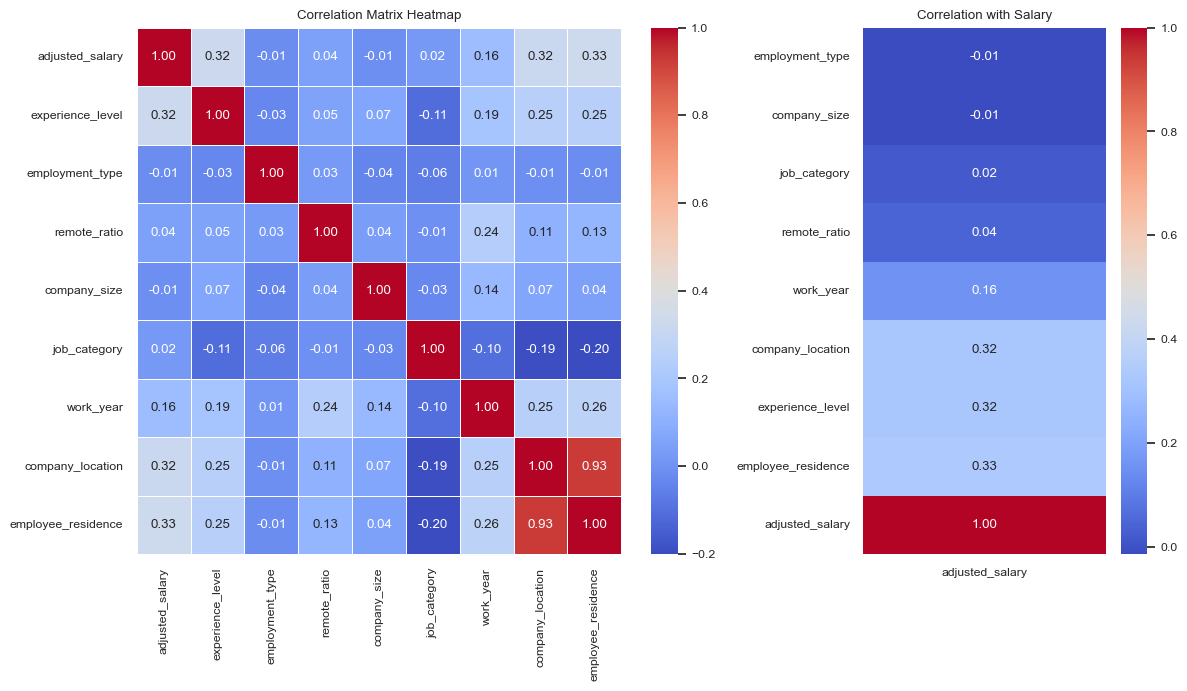

In [487]:
# Instantiate correlation matrix
correlation_matrix = processed_correlation_df.corr()

# Instantiate subplots
fig, (ax1, ax2) = plt.subplots(1,2, width_ratios=(2,1), figsize=(12,7))

#Graph I.
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', ax=ax1)
ax1.set_title("Correlation Matrix Heatmap")

corr = processed_correlation_df.corr()
#corr.drop(corr.columns[9], inplace=True)
target_corr = corr.iloc[:, 0]
# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=True)

#Graph II
#Create a heatmap of the correlations with the target column
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f', ax=ax2)
ax2.set_title('Correlation with Salary')
plt.tight_layout()
plt.show()

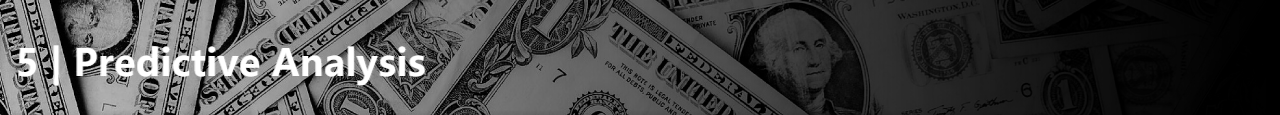

The primary goal of our investigation is to create a robust machine learning model for predicting salaries in the data science job market. In order to achieve this objective, we rely on a comprehensive dataset that includes data science job salaries and a diverse set of features, including  <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>experience level</span>, <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>employment type</span>, <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>salary in USD</span>, <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>employee residence</span>, <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>remote ratio</span>, <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>company location</span>, and <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>company size</span>,  <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>work year</span>.

### **<font color='green'>|</font> Important Features**

1. <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>experience_level [categorical]</span>: The experience level in the job during the year.

2. <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>employment_type [categorical]</span>: The type of employment for the role.

3. <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>job_category [categorical]</span>: The role worked in during the year.

4. <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>adjusted_salary [numerical]</span>: The present value salary in USD.

5. <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>employee_residence [categorical]</span>: Employee's primary country of residence in during the work year as an ISO 3166 country code.

6. <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>remote_ratio [ratio]</span>: The overall amount of work done remotely.

7. <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>company_location [categorical]</span>: The country of the employer's main office or contracting branch.

8. <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>company_size [categorical]</span>: The median number of people that worked for the company during the year as an ISO 3166 country code.

9. <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>work_year [categorical]</span>: The year the employee worked.

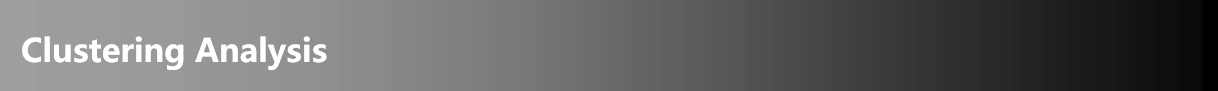

**I <font color='green'>|</font> Data Preparation**

In [488]:
# Copy data for clustering
cluster_df = df.copy()

**II <font color='green'>|</font> Convert <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>work_year</span> to *str***

In [489]:
# Convert work year from numerical to categorical
cluster_df.work_year = data.work_year.astype(str)

**III <font color='green'>|</font> Drop Renamed Duplicates**

In [490]:
cluster_df.drop(['salary_currency','salary_in_usd', 'salary', 'job_title'], axis=1, inplace=True)

**IV <font color='green'>|</font> Preprocessing**

In [491]:
# Use LabelEncoder to assign numericals to ategorical features
encoder = LabelEncoder()

# Make a an empty DataFrame to store encoded categorical data
encoded_cat = pd.DataFrame()

# Iterate categorical list to encode the values
for feature in categorical_columns:
    encoded_cat[feature] = encoder.fit_transform(data[feature])
    
#Use StandardScaler to scale numerical feature
scaler = StandardScaler()
scaled_num = pd.DataFrame(scaler.fit_transform(data[numerical_columns]), columns=numerical_columns)        

# Concactenate the preprocessed data into a dataframe
processed_cluster_df = pd.concat([scaled_num, encoded_cat], axis=1)

**V <font color='green'>|</font> T-SNE Clustering**

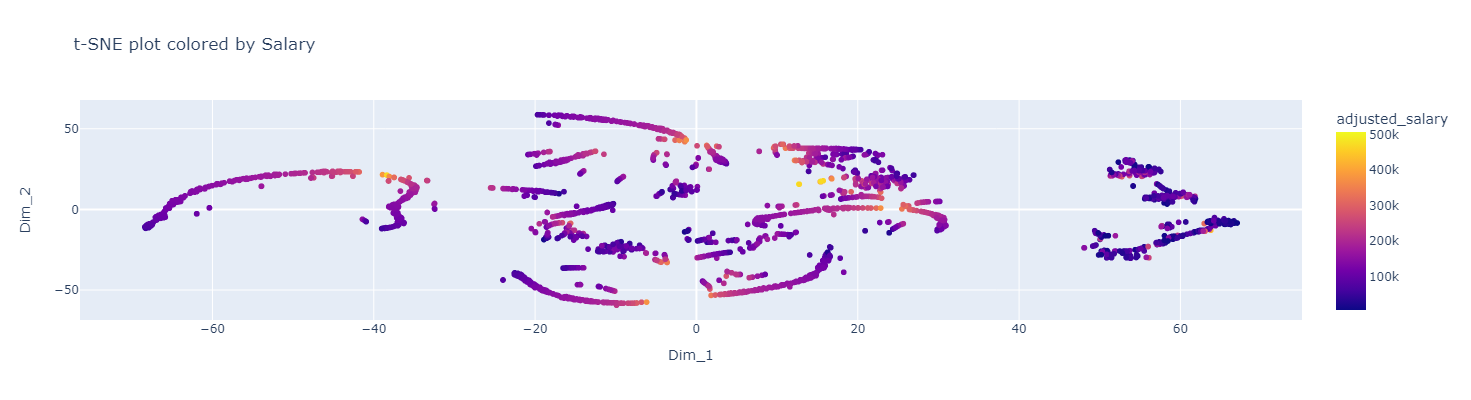

In [492]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50, learning_rate=200)
tsne_results = tsne.fit_transform(processed_cluster_df)

# Plotly Interactive plot
df_tsne = pd.DataFrame(data = tsne_results, columns = ['Dim_1', 'Dim_2'])
df_tsne['adjusted_salary'] = df['adjusted_salary']
fig = px.scatter(df_tsne, x='Dim_1', y='Dim_2', color='adjusted_salary', title='t-SNE plot colored by Salary')
fig.update_layout(autosize=False, width=600, height=400)
fig.show()

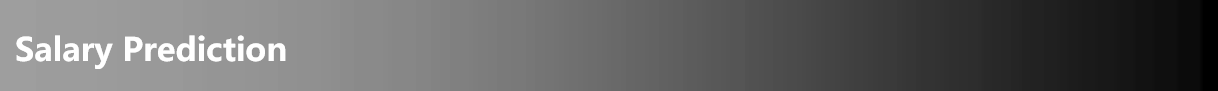

**I <font color='green'>|</font> Display Data**

In [493]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_category,adjusted_salary
0,2023,Senior Level,Full-time,Principal Data Scientist,80000,EUR,85847,Spain,Full-Remote,Spain,LARGE,Other,85847.0
1,2023,Mid/Intermediate Level,Contractor,ML Engineer,30000,USD,30000,United States,Full-Remote,United States,SMALL,Machine Learning,30000.0
2,2023,Mid/Intermediate Level,Contractor,ML Engineer,25500,USD,25500,United States,Full-Remote,United States,SMALL,Machine Learning,25500.0
3,2023,Senior Level,Full-time,Data Scientist,175000,USD,175000,Canada,Full-Remote,Canada,MEDIUM,Data Science,175000.0
4,2023,Senior Level,Full-time,Data Scientist,120000,USD,120000,Canada,Full-Remote,Canada,MEDIUM,Data Science,120000.0


**II <font color='green'>|</font> Convert <span style='color: #000000; font-family: monospace; background-color: #D7D8D8;'>work_year</span> to *str***

In [494]:
# Convert work year from numerical to categorical
df.work_year = data.work_year.astype(str)

**III <font color='green'>|</font> Drop Renamed Duplicates**

In [495]:
df.drop(['salary_currency','salary_in_usd', 'salary', 'job_title'], axis=1, inplace=True)

**IV <font color='green'>|</font> Remove Outliers with IQR Method**

In [496]:
column_name = 'adjusted_salary'

# Calculate Q1 and Q3
Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define the outlier boundaries
lower_boundary = Q1 - 1.5 * IQR
upper_boundary = Q3 + 1.5 * IQR

# Identify and remove outliers
df = df[(df[column_name] >= lower_boundary) & (df[column_name] <= upper_boundary)]

**V <font color='green'>|</font> Categorize Salary to Seven Ranges**

In [497]:
# Calculate quantiles for salary bin edges
quantiles = [0, 1/7, 2/7, 3/7, 4/7, 5/7, 6/7, 1]
bin_edges = [df['adjusted_salary'].quantile(q) for q in quantiles]

# Convert the continuous salary variable into 7 discrete bins based on quantiles
salary_labels = ['low', 'low-mid', 'mid', 'mid-high', 'high', 'very-high', 'Top']
df['salary_range'] = pd.cut(df['adjusted_salary'], bins=bin_edges, labels=salary_labels, include_lowest=True)

**VI <font color='green'>|</font> Define X and y**

In [498]:
# Define the X and y
X = df.iloc[:, :8]
y = df.iloc[:, -1]

**VII <font color='green'>|</font> Select Columns by Data Type**

In [499]:
# Select comlumns by data type
cat_columns = make_column_selector(dtype_exclude='number')
num_columns = make_column_selector(dtype_include='number')

**VIII <font color='green'>|</font> Preprocessing**

In [500]:
Imp_median = SimpleImputer(strategy='median', add_indicator=True)
scaler = StandardScaler()

Imp_constant = SimpleImputer(strategy='constant')
ohe = OneHotEncoder(handle_unknown='ignore')

# do all preprocessing
preprocessor = make_column_transformer((make_pipeline(Imp_median, scaler), num_columns),  (make_pipeline(Imp_constant, ohe), cat_columns))
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000261B5EF4490>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000261ADB1DF10>)])

**IX <font color='green'>|</font> Split Data to Train and Test**

In [501]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=99)

**X <font color='green'>|</font> Training nad Validation**

In [502]:
# Define the models
models = [
    ('Support Vector Machines', SVC(kernel='poly')),
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())]

# Model training, evaluation, and selection
best_model = None
best_cross_val = 0

print("Model performance:")
for name, model in models:
    
    pipe = make_pipeline(preprocessor, model)
    
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    #cross validate the pipeline
    
    cross_validation = cross_val_score(pipe, X, y).mean()
    print(f"{name} - Accuracy: {accuracy:.2f} - Cross Validation: {cross_validation}")

    if cross_validation > best_cross_val:
        best_cross_val = cross_validation
        best_score = accuracy
        best_model = pipe
        best_name = name
        

print(f"Best model: {best_name} with accuracy: {best_score:.2f}, and Cross Validation: {cross_validation}")

Model performance:
Support Vector Machines - Accuracy: 0.33 - Cross Validation: 0.28367071524966264
Logistic Regression - Accuracy: 0.30 - Cross Validation: 0.2836707152496626
Random Forest - Accuracy: 0.29 - Cross Validation: 0.27017543859649124
Gradient Boosting - Accuracy: 0.30 - Cross Validation: 0.2852901484480432
Best model: Gradient Boosting with accuracy: 0.30, and Cross Validation: 0.2852901484480432


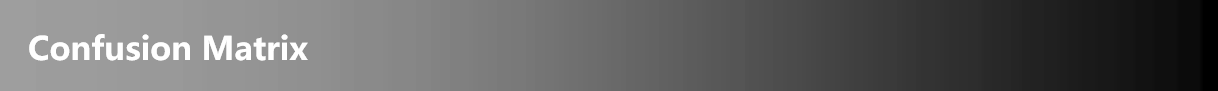

The <span style='color: #FFFFFF; font-family: monospace; background-color: #6dafd7;'>confusion matrix</span> is a way to **visualize** how many samples from each label got predicted correctly. The beauty of the confusion matrix is that it actually **allows us to see where the model fails and where the model succeeds**, especially when the labels are imbalanced. In other words, we are able to see beyond the model's accuracy.

<img src="images/confusion_matrix.png" align="center" width="700"/>

Precision:
Precision is a measure of how many of the true positive predictions were actually correct. It is defined as the number of true positives (TP) divided by the sum of true positives (TP) and false positives (FP)


<img src="images/precision.png" align="center" width="300"/>

Recall:
Recall (or Sensitivity) is a measure of how many of the actual positive cases were identified correctly. It is defined as the number of true positives (TP) divided by the sum of true positives (TP) and false negatives (FN).

<img src="images/recall.png" align="center" width="300"/>

F1-Score:
The F1 score is the harmonic mean of Precision and Recall and tries to find the balance between precision and recall. It is defined as 2 times the product of precision and recall divided by the sum of precision and recall.

<img src="images/F1.png" align="center" width="300"/>

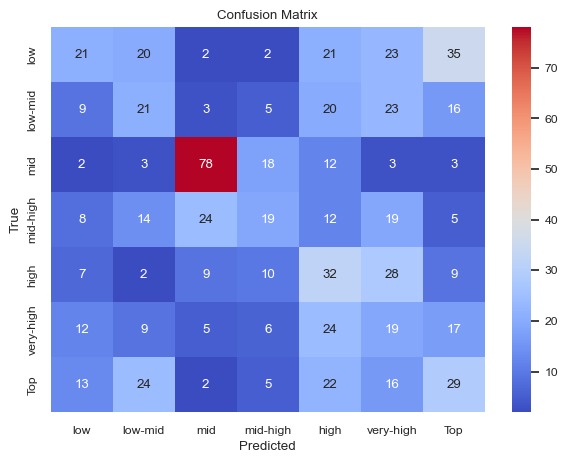

Classification Report:
              precision    recall  f1-score   support

         low       0.29      0.17      0.21       124
     low-mid       0.23      0.22      0.22        97
         mid       0.63      0.66      0.64       119
    mid-high       0.29      0.19      0.23       101
        high       0.22      0.33      0.27        97
   very-high       0.15      0.21      0.17        92
         Top       0.25      0.26      0.26       111

    accuracy                           0.30       741
   macro avg       0.30      0.29      0.29       741
weighted avg       0.31      0.30      0.29       741



In [503]:
# Generate the confusion matrix
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=salary_labels, yticklabels=salary_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=salary_labels))

### **<font color='green'>|</font> Results and Discussion**

The results indicate that the <span style='color: #FFFFFF; font-family: monospace; background-color: #6dafd7;'>Gradient Boosting Classifier</span>  exhibits the highest performance among the tested models, **attaining a cross validation, and accuracy score of 0.29**. However, it is noteworthy that the **<u>overall performance of all models is relatively low</u>**, implying potential challenges in capturing the underlying relationship between the features and the target variable (adjusted_salary).

To potentially improve the model's performance, consider employing the following strategies:

1. **Feature Engineering**: Introduce new features or transform existing ones to better capture the relationship between features and the target variable. Explore combining certain categorical features or creating interaction terms.

2. **Feature Selection**: Evaluate the importance of each feature and consider eliminating less relevant ones to reduce noise and improve the model's overall performance.

3. **Model Tuning**: Perform hyperparameter/gridsearch tuning, especially for complex models like RandomForestRegressor and GradientBoostingRegressor, to identify the optimal set of hyperparameters that could significantly boost their predictive capabilities.

4. **Try Different Models**: Experiment with alternative machine learning algorithms or ensemble methods, such as stacking or bagging, to explore if they can deliver superior predictive outcomes.

5. **Collect More Data**: If viable, increase the size of the dataset by collecting additional data, providing the models with a more diverse and informative training set, which may lead to performance improvements.

# THANK YOU!!!

Made by: edzelLagliva

Inspired by : @pannmie